In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn import datasets
from math import sqrt

import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.optimize as opt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
sns.set_style("ticks")
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

In [3]:
fs_data = pd.read_csv('../data/clean/bcdr_d0G_medc.csv')
fs_data = shuffle(fs_data, random_state=4321)
fs_data.head()

,i_mean,i_std_dev,i_maximum,i_minimum,i_kurtosis,i_skewness,s_area,s_perimeter,s_x_center_mass,s_y_center_mass,...,t_homo,t_savgh,t_svarh,t_senth,t_entro,t_dvarh,t_denth,t_inf1h,t_inf2h,diagnosis
330,0.84488,0.107010,1.00000,0.46275,0.37293,-0.39779,821,110.2254,0.24914,0.65481,...,0.33753,53.6607,2604.2744,2.8050,4.5703,19.9619,2.2568,-0.060994,0.49603,0
214,0.60594,0.104740,0.93725,0.32157,-0.53583,0.43392,35352,747.2102,0.45088,0.48224,...,0.48475,39.6157,1366.7410,3.1614,4.6640,5.0605,1.6540,-0.171470,0.75935,0
391,0.57147,0.103020,1.00000,0.38824,5.03590,1.95350,1068,138.5685,0.12689,0.57942,...,0.38948,38.5244,1296.2720,2.9177,4.6163,25.8336,2.2627,-0.084365,0.57743,0
141,0.64085,0.113310,1.00000,0.37647,1.56470,1.05970,18669,555.7300,0.19030,0.66976,...,0.48639,41.9297,1543.3750,3.1519,4.6466,9.6976,1.7967,-0.152660,0.72895,0
41,0.69425,0.065343,1.00000,0.49804,1.57680,0.69089,9037,366.8183,0.65172,0.46979,...,0.51629,45.1205,1817.2442,2.6306,4.0176,4.8484,1.6155,-0.074377,0.51490,0


In [4]:
x_values = fs_data[
    ['i_std_dev', 'i_maximum', 'i_minimum', 'i_kurtosis', 'i_skewness', 's_area', 's_perimeter', 's_y_center_mass', 's_elongation', 's_form', 's_solidity', 't_energ', 't_contr', 't_homo', 't_senth', 't_denth', 't_inf2h']]
y_values = fs_data["diagnosis"]


Proportion: 4.59 : 1


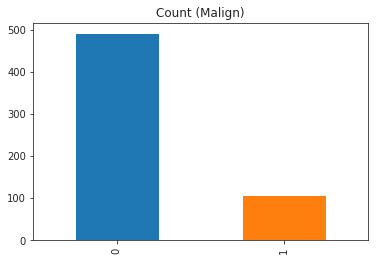

In [5]:
target_count = fs_data.diagnosis.value_counts()
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (Malign)')

In [6]:
# Data Split
from sklearn.model_selection import train_test_split
seed = 1234
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.2, random_state=seed)

Proportion: 4.56 : 1


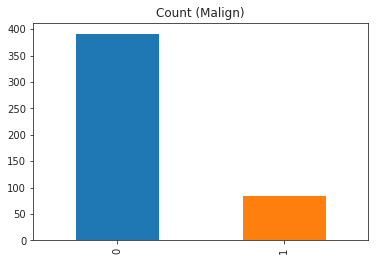

In [7]:
# train
target_count = y_train.value_counts()
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (Malign)')

<class 'pandas.core.series.Series'>
Proportion: 4.71 : 1


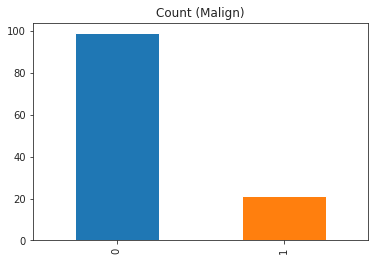

In [8]:
# test
print(type(y_test))
target_count = y_test.value_counts()
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (Malign)')

## Metrics Used

In [9]:
def print_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred=y_pred)
    sns.heatmap(cm, annot=True)
    target_names = ['0', '1']
    print(classification_report(y_test, y_pred, target_names=target_names))
    print('Accuracy: {0}'.format(accuracy_score(y_test, y_pred)))
    
def plot_roc(y_test, y_pred, model):
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.plot(fpr, tpr, marker='.', label = 'AUC: %0.2f' % auc, color= 'green')
    plt.title('{0} (ROC + AUC)'.format(model))
    plt.xlabel('False Positive Rate (x)')
    plt.ylabel('True Positive Rate (y)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

## Logistic Regression (No Normalized)

In [10]:
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(lr_model,x_values,y_values,scoring='roc_auc', cv=3)
# Print the 5-fold cross-validation scores
print(cv_scores)
print("Average 5-Fold CV Score: {0}".format(np.mean(cv_scores)))
y_pred = lr_model.predict(x_test)

[ 0.94563008  0.95359079  0.9202454 ]
Average 5-Fold CV Score: 0.9398220886605594


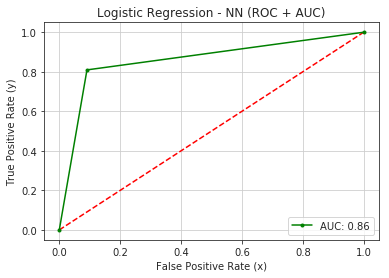

In [11]:
plot_roc(y_test, y_pred, 'Logistic Regression - NN')

---
---
---

## Logistic Regression (Normalized Z-Score)

In [12]:
from sklearn import preprocessing
from scipy.stats import zscore
fs_data_n = fs_data.drop(columns=["diagnosis"]).apply(zscore)
fs_data_n['diagnosis'] = fs_data['diagnosis']
fs_data_n.head()

,i_mean,i_std_dev,i_maximum,i_minimum,i_kurtosis,i_skewness,s_area,s_perimeter,s_x_center_mass,s_y_center_mass,...,t_homo,t_savgh,t_svarh,t_senth,t_entro,t_dvarh,t_denth,t_inf1h,t_inf2h,diagnosis
330,0.581686,-0.107090,0.377486,0.498675,-0.392593,0.134615,-0.363151,-0.591694,-0.758814,1.096846,...,-0.992944,0.579523,0.442242,0.302382,0.578196,0.066708,0.881464,0.681432,-0.336808,0
214,-0.734237,-0.164719,-0.234004,-0.433108,-0.579536,0.686167,-0.015603,0.242231,-0.054532,-0.140180,...,-0.079591,-0.710312,-0.797857,0.788206,0.652506,-0.760162,-0.322541,-0.533411,1.040429,0
391,-0.924075,-0.208386,0.377486,0.006912,0.566636,1.693883,-0.360665,-0.554588,-1.185594,0.556431,...,-0.670646,-0.810533,-0.868473,0.456008,0.614677,0.392526,0.893248,0.424434,0.088937,0
141,-0.541976,0.052852,0.377486,-0.070770,-0.147432,1.101156,-0.183515,-0.008450,-0.964227,1.204011,...,-0.069417,-0.497804,-0.620857,0.775256,0.638707,-0.502852,-0.037518,-0.326568,0.881428,0
41,-0.247884,-1.164912,0.377486,0.731588,-0.144943,0.856578,-0.280459,-0.255769,0.646608,-0.229424,...,0.116083,-0.204774,-0.346420,0.064650,0.139870,-0.771931,-0.399439,0.534267,-0.238112,0


In [13]:
nx_values = fs_data_n[
    ['i_std_dev', 'i_maximum', 'i_minimum', 'i_kurtosis', 'i_skewness', 's_area', 's_perimeter', 's_y_center_mass', 's_elongation', 's_form', 's_solidity', 't_energ', 't_contr', 't_homo', 't_senth', 't_denth', 't_inf2h']]
ny_values = fs_data_n["diagnosis"]
nx_values = fs_data_n.drop(columns=['diagnosis']) 
ny_values = fs_data_n['diagnosis']
nx_train, nx_test, ny_train, ny_test = train_test_split(nx_values, ny_values, test_size=0.2, random_state=seed)

In [14]:
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(lr_model,nx_values,ny_values,scoring='roc_auc', cv=3)
# Print the 5-fold cross-validation scores
print(cv_scores)
print("Average 5-Fold CV Score: {0}".format(np.mean(cv_scores)))
y_pred = lr_model.predict(x_test)

[ 0.9679878   0.98577236  0.94075372]
Average 5-Fold CV Score: 0.9648379624681436


              precision    recall  f1-score   support

           0       0.98      0.95      0.96        99
           1       0.79      0.90      0.84        21

   micro avg       0.94      0.94      0.94       120
   macro avg       0.89      0.93      0.90       120
weighted avg       0.95      0.94      0.94       120

Accuracy: 0.9416666666666667


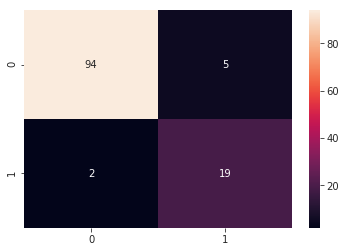

In [15]:
lr_model = LogisticRegression()
lr_model.fit(nx_train, ny_train)
ny_pred = lr_model.predict(nx_test)
print_metrics(ny_test, ny_pred)

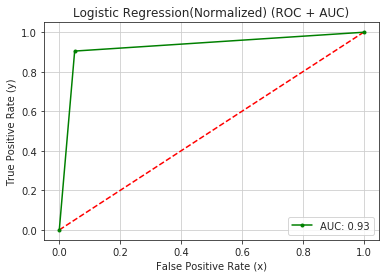

In [16]:
plot_roc(ny_test, ny_pred, 'Logistic Regression(Normalized)')

## Learning Curves w/Cross Validation

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/home/ospcx/anaconda3/envs/pyml/lib/python3.5/site-packages/matplotlib/pyplot.py'>

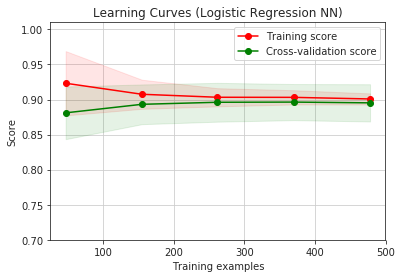

In [18]:
title = "Learning Curves (Logistic Regression NN)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression()
plot_learning_curve(estimator, title, x_values, y_values, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/home/ospcx/anaconda3/envs/pyml/lib/python3.5/site-packages/matplotlib/pyplot.py'>

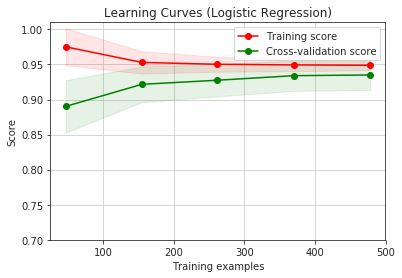

In [19]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression()
plot_learning_curve(estimator, title, nx_values, ny_values, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

# Polinomial Degree curve

In [20]:
def plot_curve(train_error, test_error):
    plt.plot(np.arange(0,train_error.shape[0]-1), train_error[1:], label = 'train error')
    plt.plot(np.arange(0,train_error.shape[0]-1),test_error[1:], label = 'test error', color= 'green')
    plt.title('Polinomial Complexity Curve')
    plt.xlabel('Polynomial Complexity (x)')
    plt.ylabel('MSE (y)')
    plt.grid()
    plt.legend()
    plt.show() 

    
def obtain_error(x_train, y_train, x_test, y_test):
    m, n = x_train.shape
    train_error = 0
    test_error = 0
    hyp_model = None
    cls_ = LogisticRegression().fit(x_train, y_train)
    hyph_train = cls_.predict(x_train)
    hyph_test = cls_.predict(x_test)
    train_error = mean_squared_error(y_train, hyph_train)
    test_error  = mean_squared_error(y_test, hyph_test)
    return train_error, test_error


def create_curve(fs_data, seed):
    train, test = train_test_split(fs_data, test_size=0.2, random_state=seed)
    
    nx_train = train.iloc[:,:-1].values
    ny_train = train.iloc[:,-1].values
    # ---- 
    nx_test = test.iloc[:,:-1].values
    ny_test = test.iloc[:,-1].values
    # ------
    train_error = np.zeros(nx_train.shape[1])
    test_error = np.zeros(nx_train.shape[1])

    n = nx_train.shape[1]
    for i in range(1, n):
        train_error[i], test_error[i] = obtain_error(nx_train[:,0:i], ny_train, nx_test[:,0:i], ny_test)
    plot_curve(train_error, test_error)

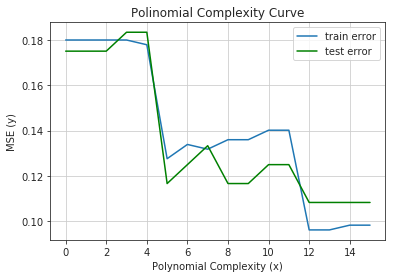

(598, 18)


In [21]:
new_data = fs_data[
    ['i_std_dev', 'i_maximum', 'i_minimum', 'i_kurtosis', 'i_skewness', 's_area', 's_perimeter', 's_y_center_mass', 's_elongation', 's_form', 's_solidity', 't_energ', 't_contr', 't_homo', 't_senth', 't_denth', 't_inf2h',
    'diagnosis']]
create_curve(new_data, seed)
print(new_data.shape)

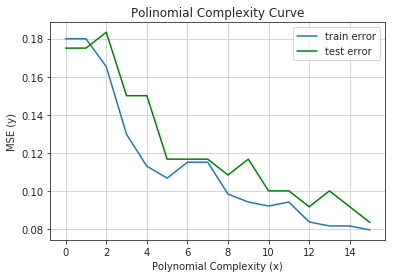

In [22]:
nnew_data = fs_data_n[
    ['i_std_dev', 'i_maximum', 'i_minimum', 'i_kurtosis', 'i_skewness', 's_area', 's_perimeter', 's_y_center_mass', 's_elongation', 's_form', 's_solidity', 't_energ', 't_contr', 't_homo', 't_senth', 't_denth', 't_inf2h',
    'diagnosis']]
create_curve(nnew_data, seed)